# Laboratorium 2


### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in self.scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in self.scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Rozwiązanie

### Tworzenie zbiorów danych

In [3]:
import random
import math
%matplotlib notebook

""" Każda funkcja rysująca dodaje nową scenę do listy scenes. By włączyć wizualizację wszystkich dodanych scen
    należy wpisać:
    plot = Plot(scenes)
    plot.draw()
    
    Wizualizcja algorytmów to osobna scena dla każdego kroku algorytmu. Na niebiesko są zaznaczone wszystkie
    punkty, na czerwono aktualnie rozpatrywane wierzchołki i ostatni bok otoczki, a na żółto pozostałe
    boki otoczki wypukłej oraz wierzchołki otoczki po wykonaniu algorytmu.
"""

scenes = []

def draw_points(points):
    scenes.append(Scene([PointsCollection(points)]))

def rand_points_a(amount, x_range, y_range): # zbiór danych z podpunktu a
    points_a = []
    for i in range(amount):
        points_a.append((random.random()*(x_range[1] - x_range[0]) + x_range[0], random.random()*(y_range[1] - y_range[0]) + y_range[0]))
    
    return points_a

def rand_points_b(amount, center, radius): # zbiór danych z podpunktu b
    points_b =[]
    for i in range(amount):
        point_angle = random.random() * math.pi * 2
        points_b.append((math.cos(point_angle)*radius + center[0], math.sin(point_angle)*radius + center[1]))
    
    return points_b

def rand_points_c(amount, lower_left, upper_right): # zbiór danych z podpunktu c
    points_c = []
    for i in range(amount):
        side = random.randint(0,3)
        if side == 0:
            points_c.append((lower_left[0], random.random()*(upper_right[1] - lower_left[1]) + lower_left[1]))
        elif side == 1:
            points_c.append((random.random()*(upper_right[0] - lower_left[0]) + lower_left[0], upper_right[1]))
        elif side == 2:
            points_c.append((upper_right[0], random.random()*(upper_right[1] - lower_left[1]) + lower_left[1]))
        elif side == 3:
            points_c.append((random.random()*(upper_right[0] - lower_left[0]) + lower_left[0], lower_left[1]))
    
    return points_c

def rand_points_d(upper_right, sides_amount, diagonals_amount): # zbiór danych z podpunktu d
    points_d = []
    points_d.append((0,0))
    points_d.append((0, upper_right[1]))
    points_d.append((upper_right[0], 0))
    points_d.append(upper_right)
    
    for i in range(sides_amount):
        points_d.append((random.random()*upper_right[0], 0))
        points_d.append((0, random.random()*upper_right[1]))

    for i in range(diagonals_amount):
        a = random.random()*upper_right[0]
        points_d.append((a, a))

        b = random.random()*upper_right[0]
        points_d.append((b, upper_right[0]-b))

    return points_d
    

# tworzenie zbiorów punktów (później używane w algorytmach)
points_a = rand_points_a(100, (-100, 100), (-100, 100))
points_b = rand_points_b(100, (0, 0), 10)
points_c = rand_points_c(100, (-10, -10), (10, 10))
points_d = rand_points_d((10, 10), 25, 20)


### funkcje pomocnicze

In [4]:
eps = 10**(-11) # eps = 10^(-11) jest najmniejszym znalezionym epsilonem, dla którego wykrywanie współlinowości
                # działa poprawnie

def det(a, b, c): # 3x3 numpy
    a = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return np.linalg.det(a)


# dodawanie sceny końcowej algorytmu z zaznaczonymi wierzchołkami i bokami otoczki wypukłej
def draw_result(all_points, result):
    lines = []
    for i in range(len(result)):
        lines.append([result[i], result[(i+1)%len(result)]])
    
    
    scenes.append(Scene([PointsCollection(all_points), 
               PointsCollection(result, 'orange')], 
              [LinesCollection(lines, 'orange')]))

# dodawanie sceny dla kroku algorytmu z wyróżnionymi wierzchołkami aktualnie rozpatrywanymi
# gdy chcemy wizualizację kolejnych kroków algorytmu to należy przekazać 
# parametr step_visualization=True do algorytmu
def draw_step(all_points, curr_result):
    lines = []
    for i in range(len(curr_result)-1):
        lines.append([curr_result[i], curr_result[i+1]])
        
    curr_line = [(curr_result[len(curr_result)-2], curr_result[len(curr_result)-1])] # ostani bok otoczki
    last_points = [curr_result[len(curr_result)-2], curr_result[len(curr_result)-1]] # ostatnie 2 wierzchołki otoczki
    
    scenes.append(Scene([PointsCollection(all_points), 
               PointsCollection(last_points, 'red')], 
              [LinesCollection(lines, 'orange'), 
               LinesCollection(curr_line, 'red')]))

# funkcja odpowiadająca za wpisywanie wyniku algorytmu do pliku; gdy chcemy wpisać wynik do pliku to należy 
# przekazać parametr to_file=True do algorytmu
def result_to_file(result):
    f = open("results.txt","w+")
    
    result_string =""
    for point in range(len(result)-1):
        result_string += ("({}, {}), ".format(result[point][0], result[point][1]))
    result_string += ("({}, {})".format(result[len(result)-1][0], result[len(result)-1][1]))
    
    f.write(result_string)
    f.close()

### Algorytm Grahama

<IPython.core.display.Javascript object>


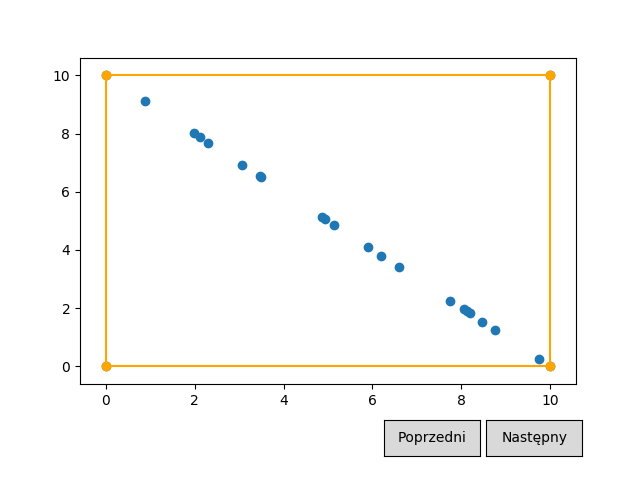

In [9]:
%matplotlib notebook

def Graham(points_coords, step_visualization=False, to_file=False):
    start = 0
    for point in range(len(points_coords)): # znajdowanie indeksu początkowego punktu
        if points_coords[point][1] < points_coords[start][1]:
            start = point
        elif points_coords[point][1] == points_coords[start][1] and points_coords[point][0] < points_coords[start][0]:
            start = point
   
    start_point = points_coords[start] # zapamiętanie punktu startowego
    points_coords.remove(start_point) # usunięcie początkowego punkty na potrzeby sortowania
    
    class Point: # klasa punktów została umieszczona w funkcji, ponieważ potrzebuje punktu początkowego otoczki
        def __init__(self, coords):
            self.x = coords[0]
            self.y = coords[1]

        # przeciążanie operatorów na potrzeby sortowania
        def __eq__(self, other):
            return abs(det(start_point, self.get_tuple(), other.get_tuple())) < eps and self.dist() == other.dist()
        
        def __gt__(self, other):
            orient = det(start_point, self.get_tuple(), other.get_tuple())
            return (orient < -eps) or (abs(orient) < eps and self.dist() > other.dist())
        
        def __lt__(self, other):
            orient = det(start_point, self.get_tuple(), other.get_tuple())
            return (orient > eps) or (abs(orient) < eps and self.dist() < other.dist())
        
        # funckcja potrzebna do usuwania punktów o takim samym kącie tworzonym z wierzchołkiem 
        # początkowym (z dokładnością do eps)
        def equal_angle(self, other):
            return abs(det(start_point, self.get_tuple(), other.get_tuple())) < eps
        
        # funckja potrzebna przy wybieraniu najdalszego wierzchołka z tych, które tworzą ten sam kąt z początkowym
        def dist(self):
            return (self.x - start_point[0])**2 + (self.y - start_point[1])**2
        
        def get_tuple(self):
            return (self.x, self.y)
            
    points = []
    for point in points_coords: # zamiana punktów opisywanych współrzędnymi na obiekty klasy Point
        points.append(Point(point))
    
    points.sort()  # sortowanie punktów po kącie tworzonym z wierzchołkiem początkowym
    
    points.insert(0, Point(start_point)) # dodanie na początek wierzchołka startowego
    points_coords.append(start_point)

    i = 1
    while i < len(points)-1:  # zostawianie tylko jednego punktu tworzącego ten sam kąt z wierzchołkiem początkowym
        if points[i].equal_angle(points[i+1]):
            points.remove(points[i])
        else:
            i += 1
                
    result = []  # stos punktów (obiektów klasy Point), który po wykonaniu algorytmu będzie szukaną otoczką wypukłą
    result.append(points[0])
    result.append(points[1])
    result.append(points[2])

    i = 2
    while i < len(points):
        if step_visualization: # wizualizacja kroków algorytmu
            draw_step(list(map(Point.get_tuple, points)), list(map(Point.get_tuple, result)))
            
        last = result.pop()
        before_last = result.pop()
        
        # sprawdzamy czy aktualnie rozpatrywany wierzchołek jest po lewej stronie od prostej (before_last, last)
        if det(before_last.get_tuple(), last.get_tuple(), points[i].get_tuple()) > 0:
            result.append(before_last)
            result.append(last)
            result.append(points[i])
            i += 1
        else:
            result.append(before_last)
    
    # wizualizacja wyniku
    draw_result(list(map(Point.get_tuple, points)), list(map(Point.get_tuple, result)))
    
    # wpisywanie wyniku do pliku
    if to_file: 
        result_to_file(list(map(Point.get_tuple, result)))

scenes = []
draw_points(points_d) # dodanie samych punktów jako pierwszą scenę
Graham(points_d, step_visualization=True, to_file=True) # wywołanie algorytmu Grahama na zbiorze b


plot = Plot(scenes)
plot.draw() 

### Algorytm Jarvisa

<IPython.core.display.Javascript object>


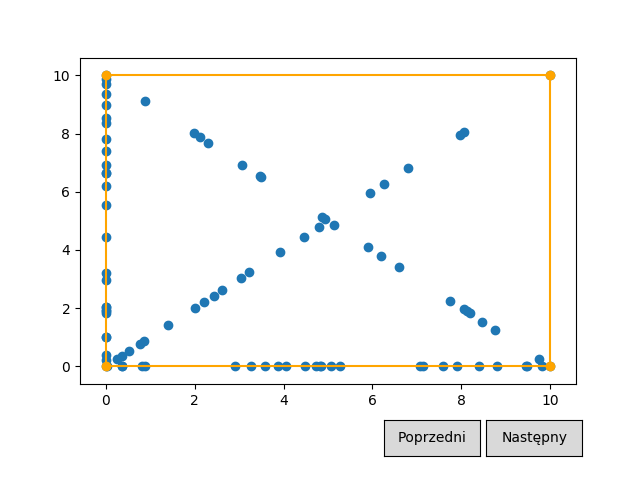

In [10]:
%matplotlib notebook

def Jarvis(points, step_visualization=False, to_file=False):
    # funckja potrzebna przy wybieraniu najdalszego wierzchołka z tych, które tworzą ten sam kąt z ostatnim
    # wierzchołkiem otoczki
    def dist(point_a, point_b):
        return (point_a[0] - point_b[0])**2 + (point_a[1] - point_b[1])**2
    
    start = 0
    for point in range(len(points)): # szukanie indeksu początkowego wierzchołka
        if points[point][1] < points[start][1]:
            start = point
        elif points[point][1] == points[start][1] and points[point][0] < points[start][0]:
            start = point
   
    start_point = points[start] # początkowy wierzchołek
    result = [start_point] # lista, która po wykonaniu algorytmu będzie zawierała wszystkie wierzchołki otoczki wypukłej
    
    last = start_point # ostatni wierzchołek otoczki
    while True:
        # szukamy jakiekolwiek punktu nie będącego ostatnim wierzchołkiem otoczki do porównywania z innymi
        next_point = points[0]
        if next_point == last:
            next_point = points[1]
            
        # szukamy następnego punktu otoczki
        for point in points:
            if point != last:
                orient = det(last, next_point, point) 
                if (orient < -eps) or (abs(orient) < eps and dist(last, point) > dist(last, next_point)):
                    next_point = point
        
        # koniec algorytmu gdy następny wierzchołek otoczki jest tym, od którego zaczęliśmy
        if next_point == start_point:
            break
        else:
            result.append(next_point)
            last = result[len(result)-1]
        
        # wizualizacja kroków algorytmu
        if step_visualization:
            draw_step(points, result)
            
    # dodanie sceny z wynikiem algorytmu
    draw_result(points, result)
    
    # wpisywanie wyniku do pliku
    if to_file:
        result_to_file(result)

scenes = []
draw_points(points_d) # dodanie samych punktów jako pierwszą scenę
Jarvis(points_d, step_visualization=True, to_file=True) # wywołanie algorytmu Jarvisa na zbiorze d

plot = Plot(scenes)
plot.draw() 

### Wydajność

In [7]:
from timeit import timeit

def check_time(algorithm, repetitions, rand_function):
    """ funkcja sprawdzająca szybkość działania algorytmów, tutaj zmieniamy ograniczenia i wielkość zbiorów danych,
        dla których chcemy sprawdzić działanie algorytmów.
    """
    def rand_points(rand_function):
        if rand_function == rand_points_a:
            points = rand_points_a(100, (-100, 100), (-100, 100))
        elif rand_function == rand_points_b:
            points = rand_points_b(100, (0, 0), 10)
        elif rand_function == rand_points_c:
            points = rand_points_c(100, (-10, -10), (10, 10))
        else:
            points = rand_points_d((10, 10), 25, 20)
        
        return points
    
    if algorithm == Graham:
        print(timeit(lambda: Graham(rand_points(rand_function)), number=repetitions))
    elif algorithm == Jarvis:
        print(timeit(lambda: Jarvis(rand_points(rand_function)), number=repetitions))
    else:
        print("invalid algorithm")
    
check_time(Graham, 100, rand_points_d)
check_time(Jarvis, 100, rand_points_d)

1.4522320670002955
0.36741814099877956
